In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 로드
file_path = './wine_review.csv'  # 데이터 파일 경로
df = pd.read_csv(file_path)

# 필요 없는 컬럼 제거 및 리뷰 텍스트와 평점만 남기기
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)
df['reviews'] = df['reviews.text'].fillna('') + ' ' + df['reviews.title'].fillna('')
df.drop(columns=['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 
                 'descriptions', 'dimension', 'ean', 'flavors', 'keys', 
                 'manufacturer', 'manufacturerNumber', 'name', 'reviews.date', 
                 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 
                 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 
                 'reviews.sourceURLs', 'reviews.userCity', 
                 'reviews.userProvince', 'reviews.username', 'sizes', 
                 'sourceURLs', 'upc', 'weight', 'reviews.text', 'reviews.title'], inplace=True)

# 데이터 전처리 및 준비
df = df[df['reviews.rating'] != 3.0]  # 평점 3인 데이터 제거
df['label'] = np.where(df['reviews.rating'] > 3, 1, 0)  # 평점 4,5 -> 1 / 평점 1,2 -> 0

# 텍스트 전처리 함수 (간단히 소문자 변환 및 불필요한 문자 제거)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 문자와 공백만 남기기
    text = ' '.join(text.split())  # 공백 처리
    return text

df['cleaned_reviews'] = df['reviews'].apply(preprocess_text)


In [4]:
# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=1000)  # 필요에 따라 max_features 조정 가능
X = tfidf.fit_transform(df['cleaned_reviews']).toarray()
y = df['reviews.rating'].values  # 평점(회귀 목표)

# 학습 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# SVR 모델 정의
svr = SVR()

# 그리드 서치를 통한 하이퍼파라미터 튜닝
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']  # RBF 커널 사용
}

# 그리드 서치 설정 (교차 검증 포함)
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# 모델 학습 및 하이퍼파라미터 튜닝
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 성능 확인
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV MSE: {-grid_search.best_score_}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1

In [6]:
# 최적의 모델로 테스트 세트 예측
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) score: {r2:.2f}")

# 교차 검증을 통한 성능 확인
cv_scores = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-cv_scores.mean():.2f}")


Mean Squared Error (MSE): 0.48
R-squared (R2) score: 0.28
Cross-validated MSE: 0.45


Accuracy: 0.96
Precision: 0.97
Recall: 1.00
F1 Score: 0.98
ROC-AUC Score: 0.65


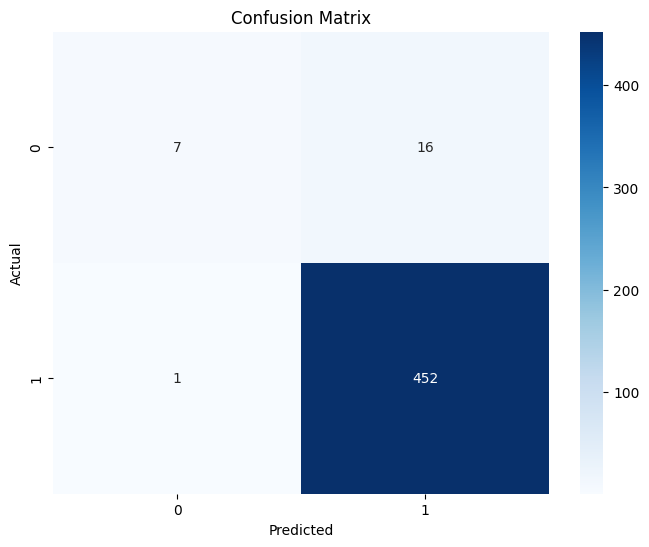

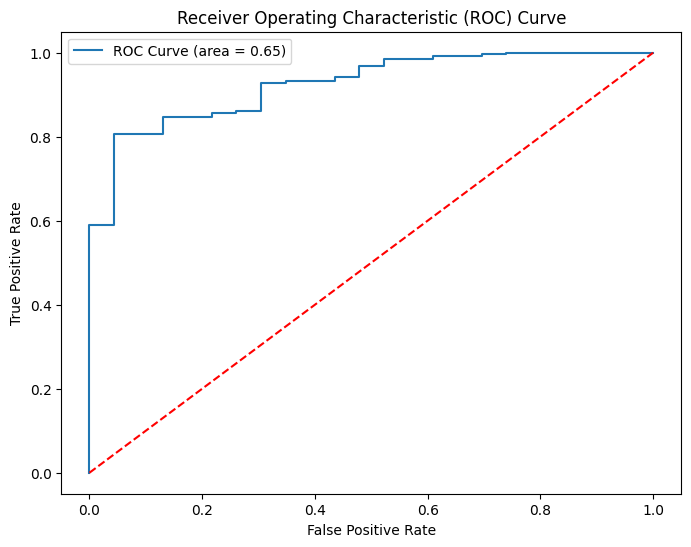

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 임계값을 기준으로 이진 분류 예측 생성
threshold = 3.5
y_pred_binary = (y_pred >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

# 성능 평가 지표 계산
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선 생성 및 시각화
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
